In [1]:
import geopandas as gpd
import fiona
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
#create a list of layers with in a file geodatabase 
layerlist = fiona.listlayers('./Schienennetz_LV03_20171210.gdb')
#print(layerlist)
netzknoten = gpd.read_file('./Schienennetz_LV03_20171210.gdb',layer='Netzknoten')
#display(netzknoten.head())
netzsegment = gpd.read_file('./Schienennetz_LV03_20171210.gdb',layer='Netzsegment')
#display(netzsegment.head())

In [3]:
#The nodes have their name and geometry(location) associated
G = nx.Graph()
for index, row in netzknoten.iterrows():
    G.add_node(row.xtf_id, geometry = row.geometry, name = row.Betriebspunkt_Name)
    
for index, row in netzsegment.iterrows():
    G.add_edge(row.rAnfangsknoten, row.rEndknoten)

In [9]:
# Create a graph only containing the giant component
names = nx.get_node_attributes(G, "name")
geometries = nx.get_node_attributes(G, "geometry")
largest_cc = max(nx.connected_components(G), key=len)

Giant_component = nx.Graph()
for n in largest_cc:
    Giant_component.add_node(n,geometry = geometries[n], name = names[n])

for index, row in netzsegment.iterrows():
    if row.rAnfangsknoten in largest_cc and row.rEndknoten in largest_cc:
        Giant_component.add_edge(row.rAnfangsknoten, row.rEndknoten) 

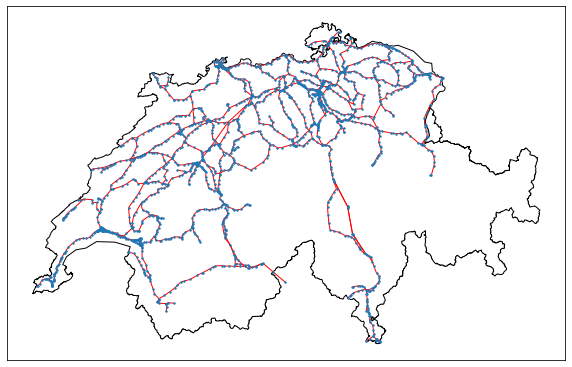

In [12]:
# Plot the giant component on the Swiss map using the network location data

geometries = nx.get_node_attributes(Giant_component, "geometry")
for key in geometries:
    geometries[key] = [float(geometries[key].x),float(geometries[key].y)]
map = gpd.read_file('./Maps/swissBOUNDARIES3D_1_3_TLM_LANDESGEBIET.shx')
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
map.plot(ax=ax, color='w', edgecolor='black', zorder=0)
nx.draw_networkx(Giant_component,pos = geometries ,with_labels= False, node_size = 2, edge_color = "r", labels = nx.get_node_attributes(G, "name"))

In [15]:
#Some figures for the Giant component: average degree <k>, global clustering coefficient C, assortativity etc.
degree_sequence = [d for n, d in Giant_component.degree()]

average_degree = sum(degree_sequence)/len(degree_sequence)
print("average degree ⟨k⟩ =",average_degree)

C = sum(nx.clustering(G).values())/len(nx.clustering(Giant_component).values())
print("global clustering C=", C)

assortativity = nx.degree_assortativity_coefficient(Giant_component)
print("assortativity=",assortativity)

print("number of connected components= ", nx.number_connected_components(Giant_component))

largest_cc = max(nx.connected_components(Giant_component), key=len)
number_largest_cc = len(largest_cc)
number_nodes = len(Giant_component.nodes())
print("Amount of nodes in the giant component: ", number_largest_cc)
print("Relative size of the giant component to the full network =", number_largest_cc/number_nodes)

average degree ⟨k⟩ = 2.1755223880597017
global clustering C= 0.030369106846718813
assortativity= 0.17512230728940192
number of connected components=  1
Amount of nodes in the giant component:  1675
Relative size of the giant component to the full network = 1.0


[0, 71, 1323, 221, 45, 10, 3, 1, 0, 1]


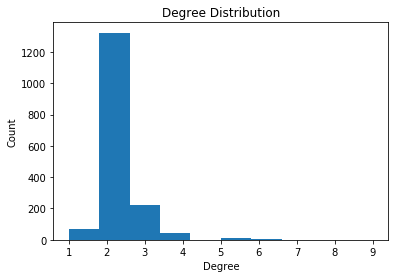

In [16]:
#Degree Distribution of the Giant component
hist = nx.degree_histogram(Giant_component)
print(hist)
plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.hist(degree_sequence, bins = len(hist))
                     
plt.show()

In [17]:
#Centralities  (Do we need the correlations between them??)
degree = sorted(list(nx.degree_centrality(Giant_component).values()), reverse =True)
closeness = sorted(list(nx.closeness_centrality(Giant_component).values()), reverse =True)
betweenness = sorted(list(nx.betweenness_centrality(Giant_component).values()), reverse =True)
eigenvector = sorted(list(nx.eigenvector_centrality(Giant_component).values()), reverse =True)

print(max(degree))
print(max(closeness))
print(max(betweenness))
print(max(eigenvector))

0.005376344086021505
0.025783993592508162
0.42997548596309076
0.4869873233382205


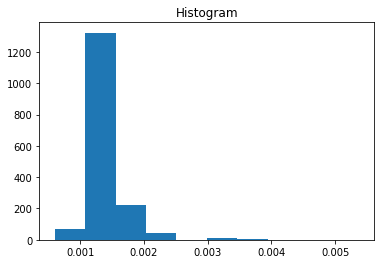

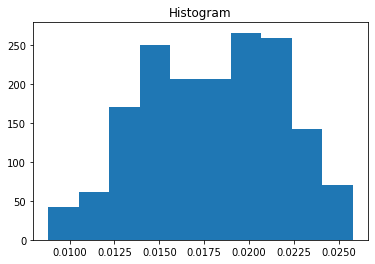

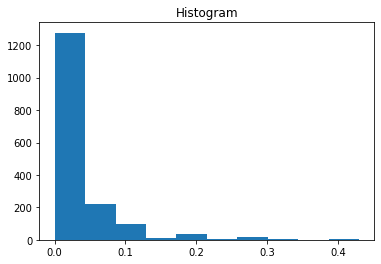

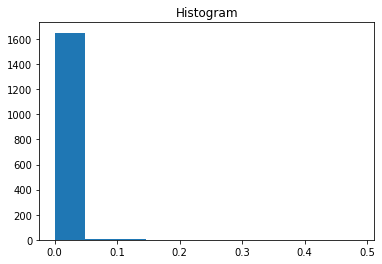

In [20]:
# Distribution of the centralities
def histogram(data, bins):
    plt.title("Histogram")
    plt.hist(data,bins=bins)
    plt.show()

histogram(degree,10)
histogram(closeness,10)
histogram(betweenness,10)
histogram(eigenvector, 10)

In [32]:
def random_attacks(G):
    temp = G.copy()
    connected_component_sizes = []
    while nx.number_of_nodes(temp) > 1:
        node_list = temp.nodes()
        to_delete = random.choice(list(node_list))
        temp.remove_node(to_delete)
        
        largest_cc = len(max(nx.connected_components(temp), key=len))
        connected_component_sizes.append(largest_cc)
    
    plt.plot(range(len(connected_component_sizes)),connected_component_sizes)
    plt.title("Random attacks")
    plt.ylabel("Size of Giant component")
    plt.xlabel("Number of removed Nodes")
    plt.show()
    
def targeted_attacks(G):
    temp = G.copy()
    connected_component_sizes = []
    node_degrees = nx.degree_centrality(temp)
    sorted_node_degrees = sorted(temp.nodes(), key=lambda n: node_degrees[n])
    while nx.number_of_nodes(temp) > 1:
        temp.remove_node(sorted_node_degrees.pop())
        largest_cc = len(max(nx.connected_components(temp), key=len))
        connected_component_sizes.append(largest_cc)
    
    plt.plot(range(len(connected_component_sizes)),connected_component_sizes)
    plt.title("Targeted attacks")
    plt.ylabel("Size of Giant component")
    plt.xlabel("Number of removed Nodes")
    plt.show()

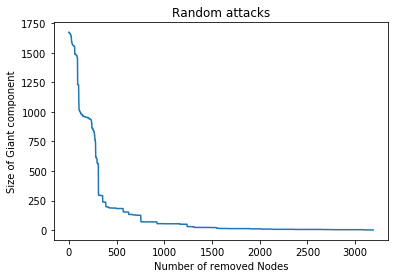

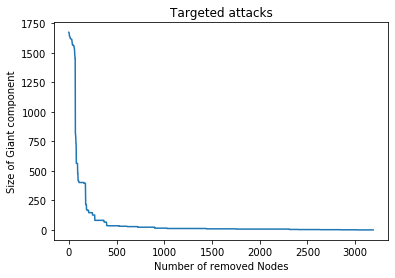

In [33]:
#Incluence of Random or targeted attacks on the remaining size of the Giant component

#Here we could think about using other attack strategies and other dependent variables

random_attacks(G)
targeted_attacks(G)